In [2]:
import pickle

import gym
import torch
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

from normalizers import Normalization, NormalizationInverse

In [3]:
class FileDataset(Dataset):
    
    def __init__(self, fn):
        self.fn = fn
        self.open_dataset()
        self.load_part()
        
    def open_dataset(self):
        self.f = open(self.fn, 'rb')
        
    def load_part(self):
        self.access_counter = 0
        try:
            self.part = pickle.load(self.f)
        except EOFError:
            self.f.close()
            self.open_dataset()
            self.load_part()
        
    def __getitem__(self, i):
        self.access_counter += 1
        if self.access_counter > len(self):
            self.load_part()
        return list(map(lambda x: x.astype(np.float32), self.part[i]))
        
    def __len__(self):
        return len(self.part)
        
    def __del__(self):
        self.f.close()

class ValueFunction(torch.nn.Module):
    
    def __init__(self, obs_size, params_size):
        super(ValueFunction, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(obs_size + params_size, 400),
            torch.nn.ReLU(),
            torch.nn.Linear(400, 400),
            torch.nn.ReLU(),
            torch.nn.Linear(400, 1)
        )
        
    def forward(self, obs, params):
        x = torch.cat([obs, params], dim=1)
        return self.model(x)

class QFunction(torch.nn.Module):
    
    def __init__(self, obs_size, params_size, action_size):
        super(QFunction, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(obs_size + params_size + action_size, 400),
            torch.nn.ReLU(),
            torch.nn.Linear(400, 400),
            torch.nn.ReLU(),
            torch.nn.Linear(400, 1)
        )
        
    def forward(self, obs, params, action):
        x = torch.cat([obs, params, action], dim=1)
        return self.model(x)

class Policy(torch.nn.Module):
    
    def __init__(self, obs_size, params_size, action_size):
        super(Policy, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(obs_size + params_size, 400),
            torch.nn.ReLU(),
            torch.nn.Linear(400, 400),
            torch.nn.ReLU(),
            torch.nn.Linear(400, action_size),
            torch.nn.Tanh(),
        )
        
    def forward(self, obs, params):
        x = torch.cat([obs, params], dim=1)
        return 2 * self.model(x)

In [4]:
v_dataset = FileDataset('value_dataset.pkl')
dataloader = DataLoader(v_dataset, batch_size=128, shuffle=True)
obs, params, values = next(iter(dataloader))
value_norm = Normalization(1)
value_norm.std = torch.FloatTensor([values.std()]).float()

obs_norm = Normalization(obs.shape[1])
obs_norm.mean = obs.mean(dim=0)
obs_norm.std = obs.std(dim=0)

params_norm = Normalization(params.shape[1])
params_norm.mean = params.mean(dim=0)
params_norm.std = params.std(dim=0)

V = ValueFunction(obs.shape[1], params.shape[1])

obs_norm.cuda()
params_norm.cuda()
value_norm.cuda()
V.train()
V.cuda()
optim = torch.optim.Adam(V.parameters(), weight_decay=1e-3)

In [5]:
for epoch in range(3000):
    for obs, params, values in dataloader:
        O = obs_norm(Variable(obs.cuda()))
        Z = params_norm(Variable(params.cuda()))
        V_ = value_norm(Variable(values.cuda()))
        loss = torch.nn.functional.mse_loss(V(O, Z), V_)
        V.zero_grad()
        loss.backward()
        optim.step()
    if epoch % 100 == 0:
        print('Epoch {}/{}'.format(epoch, 1000))

Epoch 0/1000
Epoch 100/1000
Epoch 200/1000
Epoch 300/1000
Epoch 400/1000
Epoch 500/1000
Epoch 600/1000
Epoch 700/1000
Epoch 800/1000
Epoch 900/1000
Epoch 1000/1000
Epoch 1100/1000
Epoch 1200/1000
Epoch 1300/1000
Epoch 1400/1000
Epoch 1500/1000
Epoch 1600/1000
Epoch 1700/1000
Epoch 1800/1000
Epoch 1900/1000
Epoch 2000/1000
Epoch 2100/1000
Epoch 2200/1000
Epoch 2300/1000
Epoch 2400/1000
Epoch 2500/1000
Epoch 2600/1000
Epoch 2700/1000
Epoch 2800/1000
Epoch 2900/1000


In [6]:
V.eval()
obs, params, values = next(iter(dataloader))
O = obs_norm(Variable(obs.cuda()))
Z = params_norm(Variable(params.cuda()))
V_ = value_norm(Variable(values.cuda()))
list(zip(V(O, Z).cpu().data.numpy().flatten(), V_.cpu().data.numpy().flatten()))[:10]

[(-0.13309032, -0.08523302),
 (-3.270193, -3.1242554),
 (-2.9093504, -2.866458),
 (-1.2853628, -1.376354),
 (-0.4896473, -0.44846517),
 (-0.13522452, -0.084901124),
 (-0.32849696, -0.38830024),
 (-0.27185962, -0.21128078),
 (-0.4865954, -0.44909126),
 (-1.048843, -1.0561224)]

In [7]:
q_dataset = FileDataset('q_dataset.pkl')
q_dataloader = DataLoader(q_dataset, batch_size=128, shuffle=True)
obs, obs_, params, actions, rewards = next(iter(q_dataloader))
Q = QFunction(obs.shape[1], params.shape[1], actions.shape[1]).cuda()
q_optim = torch.optim.Adam(Q.parameters(), weight_decay=1e-3)

In [8]:
V.eval()
Q.train()
gamma = 0.99
for epoch in range(3000):
    for obs, obs_, params, actions, rewards in q_dataloader:
        O = obs_norm(Variable(obs.cuda()))
        O_ = obs_norm(Variable(obs_.cuda()))
        Z = params_norm(Variable(params.cuda()))
        U = Variable(actions.cuda())
        R = value_norm(Variable(rewards.cuda()))
        Q.zero_grad()
        loss = torch.nn.functional.mse_loss(Q(O, Z, U), R + gamma * V(O_, Z))
        loss.backward()
        q_optim.step()
    if epoch % 100 == 0:
        print('Epoch {}/{}'.format(epoch, 1000))

Epoch 0/1000
Epoch 100/1000
Epoch 200/1000
Epoch 300/1000
Epoch 400/1000
Epoch 500/1000
Epoch 600/1000
Epoch 700/1000
Epoch 800/1000
Epoch 900/1000
Epoch 1000/1000
Epoch 1100/1000
Epoch 1200/1000
Epoch 1300/1000
Epoch 1400/1000
Epoch 1500/1000
Epoch 1600/1000
Epoch 1700/1000
Epoch 1800/1000
Epoch 1900/1000
Epoch 2000/1000
Epoch 2100/1000
Epoch 2200/1000
Epoch 2300/1000
Epoch 2400/1000
Epoch 2500/1000
Epoch 2600/1000
Epoch 2700/1000
Epoch 2800/1000
Epoch 2900/1000


In [9]:
obs, obs_, params, actions, rewards = next(iter(q_dataloader))
list(zip((R + gamma * V(O_, Z)).cpu().data.numpy().flatten(),
Q(O, Z, U).cpu().data.numpy().flatten()))

[(-0.25833604, -0.2650023),
 (-0.22623555, -0.20397973),
 (-0.54944247, -0.5527098),
 (-0.74925727, -0.7466393),
 (-1.4515071, -1.4175148),
 (-0.08390489, -0.08829112),
 (-0.31667238, -0.31854355),
 (-1.8858371, -1.9164882),
 (-1.2532898, -1.1960375),
 (-1.0725285, -1.0942819),
 (-0.45137706, -0.4738177),
 (-0.36405244, -0.3667941),
 (-0.57929295, -0.5886372),
 (-1.1121478, -1.0097613),
 (-0.31569174, -0.30413264),
 (-0.26729536, -0.27853101),
 (-1.0838315, -1.0258398),
 (-2.1214082, -2.0699651),
 (-0.51481646, -0.5265689),
 (-0.38244626, -0.3922896),
 (-0.34314126, -0.3866646),
 (-0.46637166, -0.49444035),
 (-0.14358595, -0.1422805),
 (-0.87791204, -0.8644337),
 (-4.535679, -4.4966125),
 (-0.7758873, -0.8036545),
 (-0.9946222, -0.95786977),
 (-1.1254731, -1.1369884),
 (-0.6363138, -0.6421214),
 (-1.8671442, -1.8588238),
 (-0.06676618, -0.053315528),
 (-0.7876857, -0.9039819)]

In [10]:
obs, obs_, params, actions, rewards = next(iter(q_dataloader))
policy = Policy(obs.shape[1], params.shape[1], actions.shape[1])
policy_opt = torch.optim.Adam(policy.parameters(), weight_decay=1e-3)
policy.cuda()

Policy(
  (model): Sequential(
    (0): Linear(in_features=18, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=400, bias=True)
    (3): ReLU()
    (4): Linear(in_features=400, out_features=7, bias=True)
    (5): Tanh()
  )
)

In [11]:
Q.eval()
for epoch in range(3000):
    for obs, obs_, params, actions, rewards in q_dataloader:
        O = obs_norm(Variable(obs.cuda()))
        Z = params_norm(Variable(params.cuda()))
        policy.zero_grad()
        U = policy(O, Z)
        loss = -Q(O, Z, U).sum() + (U ** 2).sum()
        loss.backward()
        policy_opt.step()
    if epoch % 50 == 0:
        print(-Q(O, Z, U).sum().data[0])
        print((U ** 2).sum().data[0])
        print('Epoch {}/{}'.format(epoch, 1000))

36.47389221191406
0.3457089066505432
Epoch 0/1000
24.385013580322266
0.07930387556552887
Epoch 50/1000
29.581445693969727
0.10102365911006927
Epoch 100/1000
34.42053985595703
0.07728796452283859
Epoch 150/1000
33.95734786987305
0.0995962992310524
Epoch 200/1000
27.44752311706543
0.10134600102901459
Epoch 250/1000
26.505075454711914
0.10819465667009354
Epoch 300/1000
33.285118103027344
0.08796384930610657
Epoch 350/1000
27.331392288208008
0.08469034731388092
Epoch 400/1000
31.13029670715332
0.11473171412944794
Epoch 450/1000
32.12821578979492
0.08628184348344803
Epoch 500/1000
35.721092224121094
0.11199020594358444
Epoch 550/1000
22.140432357788086
0.11062586307525635
Epoch 600/1000
33.79481887817383
0.1048588678240776
Epoch 650/1000
28.77617073059082
0.11680149286985397
Epoch 700/1000
31.310190200805664
0.12326891720294952
Epoch 750/1000
32.23411178588867
0.09736748784780502
Epoch 800/1000
30.138240814208984
0.11759686470031738
Epoch 850/1000
28.250041961669922
0.11218862980604172
Epoc

In [12]:
obs, obs_, params, actions, rewards = next(iter(q_dataloader))
O = obs_norm(Variable(obs).cuda())
Z = params_norm(Variable(params).cuda())
policy(O, Z)

Variable containing:
1.00000e-02 *
  0.6123 -0.3149  0.0254  0.3780 -0.0079 -1.6828 -0.5863
  3.9200  0.8016 -3.2435  0.3036 -0.4587 -0.7278  1.6921
 -0.2203  3.5576  0.4977 -1.8740 -0.5076  0.5001 -0.4833
 -0.9771 -4.3675  0.7175 -0.0042 -1.7637  1.1436  1.3261
  2.6981 -0.7015 -2.4304 -1.4848 -2.6430  0.7728  4.3100
  0.1475 -1.6741  1.2597 -0.5295  2.7992  0.2179 -5.7483
 -0.1156  2.1131 -2.0877 -0.6397  0.9042  0.4141 -1.5236
  4.3233 -4.9378 -4.1355  3.4972  1.9722 -0.9067 -3.2555
  0.3052 -4.9824 -0.4607  3.4206 -0.2770 -0.6339 -0.3770
  2.5423 -3.6782 -2.6442  2.3909  0.1963 -0.4790 -0.5913
  0.6066 -4.7768 -0.2425  1.6004  1.1045  0.7858 -2.4418
  2.4646  2.8561 -1.6813 -2.7845 -2.0047  0.4530  2.8300
 -1.5845  2.6690  0.5944 -1.3046  0.7115 -1.7450 -2.5493
  2.8614  2.0113 -3.1274 -0.1827  1.9345 -1.4098 -1.7068
  1.1144  3.7867 -1.8957 -1.4210  1.4229 -1.5880 -0.8658
  1.4810  2.9005 -1.4825  1.0102  0.9865 -2.0209 -2.6164
  3.4437  1.0478 -2.2500 -1.0605  0.6287  0.1097  0.2

In [13]:
env = gym.make('YumiReacher-v0')

In [14]:
#export LD_LIBRARY_PATH=$HOME/.mujoco/mjpro150/bin
#export LD_PRELOAD=/usr/lib/x86_64-linux-gnu/libGLEW.so
os.environ.putenv('DISPLAY', ':0')

NameError: name 'os' is not defined

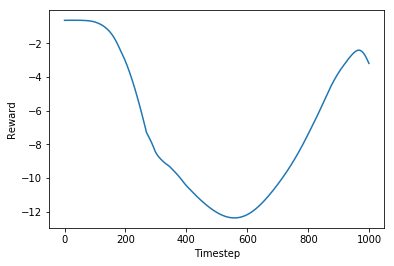

In [19]:
policy.eval()
o = env.reset()
rs = []
for _ in range(1000):
    O = obs_norm(Variable(torch.FloatTensor([o])).cuda())
    Z = params_norm(Variable(torch.FloatTensor([[0.0, 0.0, 0.2, 0.9]])).cuda())
    U = policy(O, Z)
    u = U.cpu().data.numpy().flatten()
    o, r, done, info = env.step(u)
    rs.append(r)
plt.ylabel('Reward')
plt.xlabel('Timestep')
plt.plot(rs)
plt.savefig('/home/isacar/workspace/rl-paper/rollout-rewards.pdf')
plt.show()